# Trimble / Bilberry : AI Engineer technical exercise

## 💻 Data

###  Path & Import


In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 14.5 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.models import ResNet50_Weights
from torchvision.models import ResNet101_Weights

from torchmetrics import Accuracy

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

In [ ]:
!wget https://github.com/AslanChappe/BilberryTech/blob/main/dataset.zip

In [ ]:
!unzip '/content/dataset.zip' #path to dataset folder

Archive:  /content/dataset.zip
   creating: dataset/
   creating: dataset/roads/
  inflating: dataset/roads/42.jpg    
  inflating: dataset/roads/37.jpg    
  inflating: dataset/roads/40.jpg    
  inflating: dataset/roads/38.jpg    
  inflating: dataset/roads/10.jpg    
  inflating: dataset/roads/41.jpg    
  inflating: dataset/roads/39.jpg    
  inflating: dataset/roads/1.jpg     
  inflating: dataset/roads/44.jpg    
  inflating: dataset/roads/2.jpg     
  inflating: dataset/roads/43.jpg    
  inflating: dataset/roads/11.jpg    
  inflating: dataset/roads/3.jpg     
  inflating: dataset/roads/12.jpg    
  inflating: dataset/roads/4.jpg     
  inflating: dataset/roads/13.jpg    
  inflating: dataset/roads/5.jpg     
  inflating: dataset/roads/14.jpg    
  inflating: dataset/roads/6.jpg     
  inflating: dataset/roads/15.jpg    
  inflating: dataset/roads/7.jpg     
  inflating: dataset/roads/16.jpg    
  inflating: dataset/roads/8.jpg     
  inflating: dataset/roads/20.jpg    
  infla

In [ ]:
ROOT = "/content"  # path to the folder containing the dataset
DATA_DIR = ROOT + "/dataset"
TEST_DIR = ROOT + "/test_images"

In [ ]:
shutil.move("/content/dataset/test_images", "/content/test_images")

'/content/test_images'

In [ ]:
# Path to the folder containing images
INPUT_FOLDER = "/content/test_images"  # Replace with the path to the test_images folder

# Path to the "Roads" and "Fields" subfolders inside test_images
roads_folder = os.path.join(INPUT_FOLDER, "roads")
fields_folder = os.path.join(INPUT_FOLDER, "fields")

# Create the subfolders if they don't exist already
os.makedirs(roads_folder, exist_ok=True)
os.makedirs(fields_folder, exist_ok=True)

# List of file names corresponding to road images
road_image_names = ["2.jpeg", "3.jpeg", "5.jpeg", "7.jpeg", "8.jpeg"]

# Iterate through the images in the input folder
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(".jpeg") or filename.endswith(".png"):
        image_path = os.path.join(INPUT_FOLDER, filename)

        # If the file name is in the list of road image names
        if filename in road_image_names:
            destination_folder = roads_folder
        else:
            destination_folder = fields_folder

        # Move the image to the appropriate subfolder
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(image_path, destination_path)
        print(f"Image {filename} moved to {destination_folder}")

###Dataset


In [ ]:
class ImageDataset(Dataset):
    """
    Custom dataset class for image data with labels.

    This class extends the PyTorch `Dataset` class and provides a convenient way to load image data
    along with corresponding labels. It can also normalize data according to the mean and std from the
    dataset.

    Parameters:
        DATA_DIR (str): Path to the root directory of the image dataset.
        transform (Optional[transforms.Compose]): A sequence of transformations to apply to the images.
        normalize (bool, optional): If True, normalize the images using computed mean and standard deviation.

    Attributes:
        class_names (List[str]): List of class names extracted from the dataset.

    Example:
        >>> dataset = ImageDataset(DATA_DIR, transform=transform, normalize=True)
        >>> dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    """

    def __init__(self, DATA_DIR, transform=None, normalize=False):
        """
        Initialize the ImageDataset.

        Args:
            data_dir (str): Path to the root directory of the image dataset.
            transform (Optional[transforms.Compose]): A sequence of transformations to apply to the images.
            normalize (bool, optional): If True, normalize the images using computed mean and standard deviation.
        """
        self.dataset = torchvision.datasets.ImageFolder(
            root=DATA_DIR, transform=transform
        )
        self.class_names = self.dataset.classes
        self.normalize = normalize

        if self.normalize:
            self.mean, self.std = self._compute_dataset_stats()

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get a sample from the dataset.

        Args:
            index (int): Index of the sample.

        Returns:
            tuple: A tuple containing the normalized image data as a tensor and its corresponding label.
        """
        image, label = self.dataset[index]

        if self.normalize:
            image = self._normalize_image(image)

        return image, label

    def _compute_dataset_stats(self):
        """
        Compute the mean and standard deviation of the dataset for normalization.

        Returns:
            tuple: A tuple containing the computed mean and standard deviation values.
        """
        channel_means = []
        channel_stds = []

        for images, _ in DataLoader(self.dataset, batch_size=1, shuffle=False):
            numpy_images = images.numpy()
            batch_means = np.mean(numpy_images, axis=(0, 2, 3))
            batch_stds = np.std(numpy_images, axis=(0, 2, 3))

            channel_means.append(batch_means)
            channel_stds.append(batch_stds)

        mean_values = np.mean(channel_means, axis=0)
        std_values = np.mean(channel_stds, axis=0)

        return mean_values.tolist(), std_values.tolist()

    def _normalize_image(self, image):
        """
        Normalize the input image using computed mean and standard deviation.

        Args:
            image (PIL.Image): Input image.

        Returns:
            torch.Tensor: Normalized image tensor.
        """
        normalize = transforms.Normalize(mean=self.mean, std=self.std)
        image = normalize(image)
        return image

    def smote_oversample(self, target_class, oversample_ratio):
        """
        Apply SMOTE oversampling to a specific class in the dataset.

        Args:
            target_class (int): The index of the class to oversample.
            oversample_ratio (float): The ratio of oversampling compared to the original class size.

        Returns:
            Dataset: A new dataset containing both original and SMOTE oversampled data for the target class.
        """
        class_indices = [
            i for i, (_, label) in enumerate(self.dataset.imgs) if label == target_class
        ]
        class_data = [self.dataset[i][0] for i in class_indices]

        smote = SMOTE(sampling_strategy=oversample_ratio)

        # Apply SMOTE to each image individually
        smote_data = []
        for image in class_data:
            image_numpy = image.numpy()
            image_flat = image_numpy.reshape(
                -1, image_numpy.shape[-1]
            )  # Flatten the image
            smote_samples, _ = smote.fit_resample(
                image_flat, [0]
            )  # Apply SMOTE on flattened image
            smote_samples = smote_samples.reshape(
                -1, image_numpy.shape[0], image_numpy.shape[1], image_numpy.shape[2]
            )  # Reshape back to original image shape
            smote_samples = torch.tensor(smote_samples, dtype=torch.float32)
            smote_data.append(smote_samples)

        # Create a new dataset with both original and SMOTE oversampled data
        smote_dataset = Subset(
            self.dataset, class_indices
        ) + torch.utils.data.TensorDataset(
            torch.stack(smote_data),
            torch.full((len(smote_data),), target_class, dtype=torch.long),
        )

        return smote_dataset

In [ ]:
class RoadFieldDataLoader:
    """
    Custom DataLoader for splitting and loading datasets into training, validation, and test sets.

    This class takes a dataset and divides it into training, validation, and test sets based on the provided split ratios.
    It creates instances of CustomDataset for each set and DataLoader instances for easy batch loading.

    Parameters:
        dataset (Dataset): The dataset to be divided and loaded.
        batch_size (int): The batch size for DataLoader.
        testset (bool, optional): If True, split dataset into train, validation, and test sets. If False, split into train and validation sets.
        train_size (float, optional): The ratio of training set size (0.6 by default).
        val_size (float, optional): The ratio of validation set size (0.2 by default).
        test_size (float, optional): The ratio of test set size (0.2 by default).
        shuffle (bool, optional): If True, shuffle the data within DataLoader (default is True).

    Example:
        >>> dataset = YourCustomDataset(DATA_DIR, transform=transform)
        >>> dataloader = CustomDataLoader(dataset, batch_size=32, testset=True)
        >>> train_loader, val_loader, test_loader = dataloader.get_loaders()
    """

    def __init__(
        self,
        dataset,
        batch_size,
        testset=True,
        train_size=0.6,
        val_size=0.2,
        test_size=0.2,
        shuffle=True,
    ):
        """
        Initialize the CustomDataLoader.

        Args:
            dataset (Dataset): The dataset to be divided and loaded.
            batch_size (int): The batch size for DataLoader.
            testset (bool, optional): If True, split dataset into train, validation, and test sets. If False, split into train and validation sets.
            train_size (float, optional): The ratio of training set size (0.6 by default).
            val_size (float, optional): The ratio of validation set size (0.2 by default).
            test_size (float, optional): The ratio of test set size (0.2 by default).
            shuffle (bool, optional): If True, shuffle the data within DataLoader (default is True).
        """
        self.dataset = dataset
        self.testset = testset
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Dividing the data into train, validation, and test sets
        if self.testset:
            train_data, temp_data = train_test_split(
                dataset, test_size=1 - train_size, random_state=42
            )
            val_data, test_data = train_test_split(
                temp_data, test_size=test_size / (val_size + test_size), random_state=42
            )
        else:
            train_data, val_data = train_test_split(
                dataset, test_size=1 - train_size, random_state=42
            )

        # Creating DataLoader instances for each set
        self.train_loader = DataLoader(
            train_data, batch_size=self.batch_size, shuffle=self.shuffle
        )
        self.val_loader = DataLoader(
            val_data, batch_size=self.batch_size, shuffle=False
        )
        if self.testset:
            self.test_loader = DataLoader(
                test_data, batch_size=self.batch_size, shuffle=False
            )

    def get_loaders(self):
        """
        Get DataLoader instances for training, validation, and test sets.

        Returns:
            tuple: A tuple containing DataLoader instances for training, validation, and test sets (if testset=True).
        """
        if self.testset:
            return self.train_loader, self.val_loader, self.test_loader
        else:
            return self.train_loader, self.val_loader

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

BATCH_SIZE = 4

RoadFieldData = ImageDataset(DATA_DIR, transform=transform, normalize=True)

data_loader = RoadFieldDataLoader(
    RoadFieldData,
    batch_size=BATCH_SIZE,
    testset=False,
    train_size=0.6,
    val_size=0.4,
    shuffle=True,
)
train_loader, val_loader = data_loader.get_loaders()

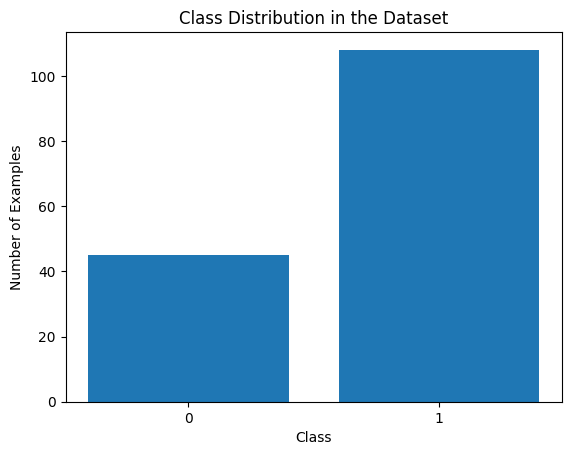

In [ ]:
y_train = [label for _, label in RoadFieldData.dataset]

# Count the number of examples per class
class_counts = np.bincount(y_train)

# Create a list of class labels
class_labels = list(range(len(class_counts)))

# Create a bar chart to visualize the class distribution
plt.bar(class_labels, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in the Dataset")
plt.xticks(class_labels)
plt.show()

## 🕸 Model

In [ ]:
class RoadFieldResNet(pl.LightningModule):
    """
    Convolutional neural network for binary classification using PyTorch Lightning.

    This class defines a neural network model based on ResNet18 architecture for binary classification tasks.

    Args:
        n_output (int): Number of output units (classes) for binary classification.

    Example:
        >>> model = RoadFieldResNet(n_output=1)

    """

    def __init__(self, N_OUTPUT):
        """
        Initialize the RoadFieldResNet model.

        Args:
            n_output (int): Number of output units (classes) for binary classification.
        """
        super(RoadFieldResNet, self).__init__()

        self.save_hyperparameters()
        self.N_OUTPUT = N_OUTPUT

        # Setting up accuracy metrics
        self.train_acc = Accuracy(task="binary")
        self.val_acc = Accuracy(task="binary")
        self.test_acc = Accuracy(task="binary")

        # ResNet model

        # weights = ResNet50_Weights.DEFAULT
        # resnet = models.resnet50(weights=weights)

        weights = ResNet101_Weights.DEFAULT
        resnet = models.resnet101(weights=weights)

        # Replace the fully connected layer of ResNet to match the desired output size
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, self.N_OUTPUT)
        self.resnet = resnet

        # Weighted BCE Loss
        positive_weight, negative_weight = self.compute_class_weights(train_loader)
        self.loss = nn.BCEWithLogitsLoss(
            pos_weight=negative_weight, weight=positive_weight
        )

    def configure_optimizers(self):
        """
        Configure optimizer and learning rate scheduler.

        Returns:
            torch.optim.Optimizer: Optimizer for training.
        """
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0001)
        return optimizer

    def compute_class_weights(self, train_loader):
        """
        Calculate class weights based on the training dataset.

        Parameters:
            train_loader (DataLoader): The DataLoader for the training dataset.

        Returns:
            positive_weight (float): Weight for the positive class.
            negative_weight (float): Weight for the negative class.
        """
        train_labels = []

        # Iterate through the DataLoader to get the labels
        for _, labels in train_loader:
            train_labels.extend(labels.tolist())  # Convert tensors to list

        # Convert the list into a PyTorch tensor
        train_labels = torch.tensor(train_labels)

        num_positive_samples = torch.sum(train_labels)
        num_negative_samples = len(train_labels) - num_positive_samples
        total_samples = len(train_labels)

        # Calculate class weights
        positive_weight = num_negative_samples / total_samples
        negative_weight = num_positive_samples / total_samples

        return positive_weight, negative_weight

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the model.
        """
        x = self.resnet(x)

        x = torch.sigmoid(x)
        return x

    def training_step(self, train_batch, batch_idx):
        """
        Training step for the model.

        Args:
            train_batch (tuple): Batch of input data and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Loss tensor for the training step.
        """
        x, y = train_batch
        x = self.forward(x)

        y = y.float().view(-1, 1)

        loss = self.loss(x, y)
        preds = x.view(-1, 1)

        self.train_acc.update(preds, y)
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc.compute(), prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        """
        Validation step for the model.

        Args:
            val_batch (tuple): Batch of input data and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Loss tensor for the validation step.
        """
        x, y = val_batch

        x = self.forward(x)
        y = y.float().view(-1, 1)

        loss = self.loss(x, y)
        preds = x.view(-1, 1)

        self.val_acc.update(preds, y)
        self.log("val_loss", loss)
        self.log("val_acc", self.val_acc.compute(), prog_bar=True)
        return loss

    def test_step(self, val_batch, batch_idx):
        """
        Test step for the model.

        Args:
            val_batch (tuple): Batch of input data and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Loss tensor for the test step.
        """
        x, y = val_batch

        x = self.forward(x)
        y = y.float().view(-1, 1)

        loss = self.loss(x, y)
        preds = x.view(-1, 1)

        self.test_acc.update(preds, y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

In [ ]:
# Setting up the model workout
N_OUTPUT = 1
model = RoadFieldResNet(N_OUTPUT)

tb_logger = TensorBoardLogger("tb_log", name="RoadFieldModel")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = pl.Trainer(max_epochs=18, logger=tb_logger, log_every_n_steps=10)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 115MB/s] 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

## 📉 Evaluation


In [ ]:
# Uncomment to get Tensorboard from the model
!pkill -f "tensorboard --logdir"
%reload_ext tensorboard
%tensorboard --logdir "/content/tb_log/RoadFieldModel/version_0"  --port=605

F1 Score: 1.0
Confusion Matrix:
[[5 0]
 [0 5]]


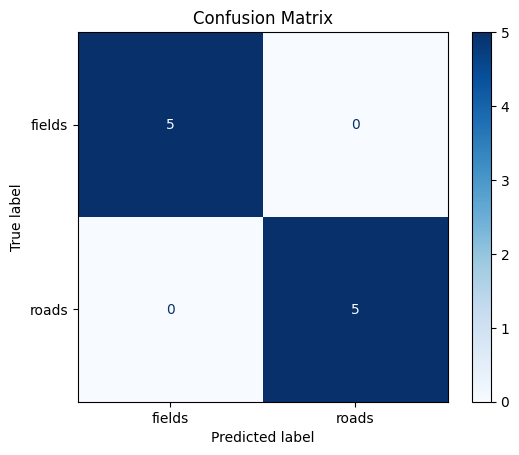

In [ ]:
model = RoadFieldResNet(N_OUTPUT)
model.load_state_dict(torch.load("/content/best_model.pth"))
model.eval()

mean, std = [0.4300263226032257, 0.43572303652763367, 0.3928486704826355], [
    0.22674061357975006,
    0.22683382034301758,
    0.24248333275318146,
]


transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    "/content/test_images", transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average="weighted")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

class_names = RoadFieldData.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

[[0.03132344]
 [0.00675253]
 [0.23540856]
 [0.32826942]
 [0.00840752]
 [0.99504954]
 [0.9984785 ]
 [0.99984324]
 [0.9968088 ]
 [0.95909077]] [0 0 0 0 0 1 1 1 1 1]


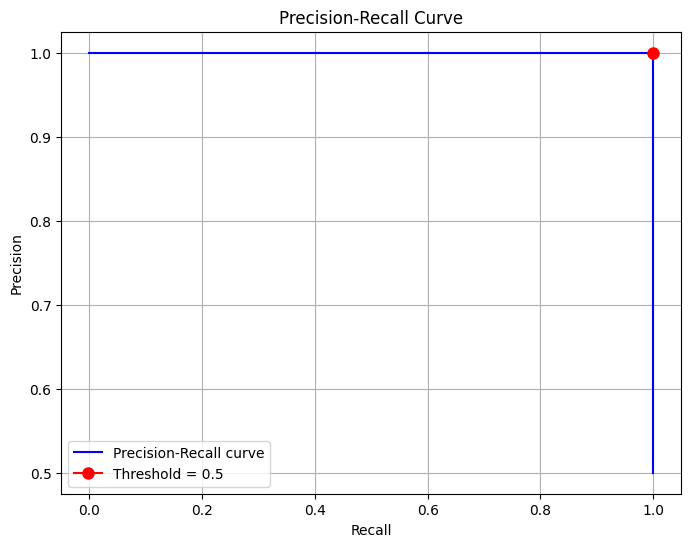

In [ ]:
# Store probability scores and true labels in lists
y_scores = []
y_true = []

# Iterate through the test data and obtain probability scores
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())  # Convert tensors to numpy arrays
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy arrays

# Convert lists to numpy arrays
y_scores = np.array(y_scores)
y_true = np.array(y_true)
print(y_scores, y_true)
# Calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Find the index of the threshold closest to 0.5
threshold_index = np.where(thresholds >= 0.5)[0][0]

# Plot the precision-recall curve with the threshold of 0.5
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="b", label="Precision-Recall curve")
plt.plot(
    recall[threshold_index],
    precision[threshold_index],
    marker="o",
    color="r",
    markersize=8,
    label="Threshold = 0.5",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

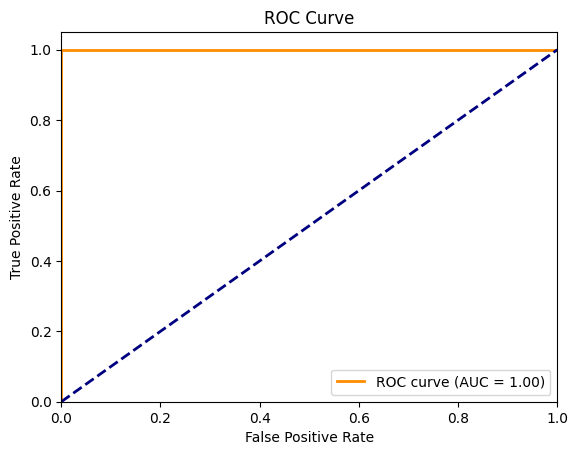

In [ ]:
predicted_scores = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_scores.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predicted scores to probabilities using the activation function
predicted_probs = torch.tensor(predicted_scores)

# Convert probabilities and true labels to NumPy arrays
predicted_probs = predicted_probs.numpy()
true_labels = np.array(true_labels)

# Calculate false positive rates and true positive rates from the predicted probabilities
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

This image is 84.00 percent Field and 16.00 percent Road.


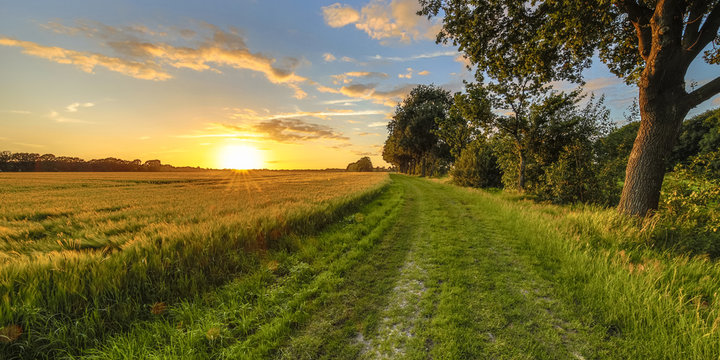

In [ ]:
# Getting an image from an URL
urllib.request.urlretrieve(
    "https://t3.ftcdn.net/jpg/01/97/28/16/360_F_197281614_aLQiuOxEY3DVvQGHv7klsLZoIL26qJwH.jpg",
    "test_img_url.png",
)

image = Image.open("test_img_url.png")

image_test = transform(image)
image_test = image_test.unsqueeze(0)

# model.to(device)
pred = model(image_test)

score = int(pred.item() * 100)

print(
    "This image is %.2f percent Field and %.2f percent Road." % ((100 - score), score)
)

display(image)